#  Trabajo Práctico 2: Análisis con Árbol de decisión - Organización de Datos

**Alumnos y Padrón**  
* Grassano, Bruno - 103855  
* Romero, Adrián   - 103371

https://github.com/brunograssano/TP-Organizacion-de-datos

## Configuraciones iniciales

Cargamos las bibliotecas que se van a estar usando a lo largo de este notebook.

In [1]:
import graphviz
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn import tree
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, StratifiedKFold

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import roc_curve, auc

from sklearn.tree import plot_tree

import graphviz

In [2]:
from sklearn.tree import DecisionTreeClassifier

In [3]:
from preprocessing import prepararSetDeDatos
from preprocessing import prepararSetDeHoldout
from preprocessing import prepararSetDeValidacion
from preprocessing import expansionDelDataset
from preprocessing import conversionAVariablesNumericas
from preprocessing import conversionAVariablesNumericasNormalizadas

In [4]:
from sklearn.model_selection import GridSearchCV

In [5]:
from funcionesAuxiliares import mostrarAUCScore
from funcionesAuxiliares import mostrarROCCurve
from funcionesAuxiliares import mostrarMatrizDeConfusion
from funcionesAuxiliares import escribirPrediccionesAArchivo
from funcionesAuxiliares import obtenerDatasets
from funcionesAuxiliares import obtenerHoldout

## Carga y preparación del set de datos

In [6]:
X,y = obtenerDatasets()

X = prepararSetDeDatos(X)
y = prepararSetDeValidacion(y)

# Árboles de decisión

Los árboles de decisición son algoritmos de aprendizaje supervisado utilizados para la clasificación. Se construyen iterativamente a partir de encontrar "el mejor feature" en cada iteración para agregar como nodo al árbol. 

Este feature se encuentra a partir de los criterios de impureza de Gini o de ganancia de información. Una vez encontrado el mejor feature, se agrega como nodo al árbol y luego se crean ramas para cada uno de los valores que puede tomar el feature.

Finalmente, cada hoja del árbol se asociará con una clase según la cantidad de instancias de cada clase que le hayan llegado.

Los parámetros que se deben definir son:

**Profundidad máxima:** le impone un limite a la profundidad de máxima al árbol, los árboles muy profundos tienden a overfittear.

**Criterio:** es el criterio con el que se escoge el "mejor feature" para ocupar un nodo. Decimos que un feature es mejor que otro si maximiza la ganancia de información o si tiene baja impureza según el criterio de impureza Gini.

Construiremos dos árboles clasificadores: un primer árbol utilizando un preprocesamineto que convierte las variables categóricas a numéricas y un segundo árbol utilizando un preprocesamineto que además las normaliza.

A priori, esperamos que los estos árboles sean similares, pues normalizar los valores en un árbol cambia el criterio de corte de sus nodos pero no hay cálculos de distancias, por lo que el árbol no es afectado notablemente por no normalizar.

In [7]:
X_normalizado = conversionAVariablesNumericasNormalizadas(X)
nombre_de_los_features, X_sin_normalizar = conversionAVariablesNumericas(X)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_sin_normalizar, y, test_size=0.25, random_state=0)
X_normalizado_train, X_normalizado_test, y_normalizado_train, y_normalizado_test = train_test_split(X_normalizado, y, test_size=0.25, random_state=0)

#### Árbol con datos de entrenamiento sin normalizar

In [9]:
arbol_clasificador = DecisionTreeClassifier()
arbol_clasificador = GridSearchCV(arbol_clasificador, {'criterion':('gini', 'entropy'), 'max_depth':[1,2,3,4,5,6,7,8,9,10]}, n_jobs = -1)
arbol_clasificador.fit(X_train, y_train)
y_pred = arbol_clasificador.predict(X_test)

In [10]:
arbol_clasificador.best_params_

{'criterion': 'gini', 'max_depth': 3}

#### Árbol con datos de entrenamiento normalizado

In [11]:
arbol_clasificador_normalizado = DecisionTreeClassifier()
arbol_clasificador_normalizado = GridSearchCV(arbol_clasificador_normalizado, {'criterion':('gini', 'entropy'), 'max_depth':[1,2,3,4,5,6,7,8,9,10]}, n_jobs = -1)
arbol_clasificador_normalizado.fit(X_normalizado_train, y_normalizado_train)
y_pred_normalizado = arbol_clasificador_normalizado.predict(X_normalizado_test)

In [12]:
arbol_clasificador_normalizado.best_params_

{'criterion': 'gini', 'max_depth': 3}

### Evaluación de métricas

In [13]:
print(classification_report(y_pred, y_test, target_names=["Volveria", "No Voleria"]))

              precision    recall  f1-score   support

    Volveria       0.90      0.83      0.86       132
  No Voleria       0.71      0.83      0.77        69

    accuracy                           0.83       201
   macro avg       0.81      0.83      0.81       201
weighted avg       0.84      0.83      0.83       201



In [14]:
print(classification_report(y_pred_normalizado, y_test, target_names=["Volveria", "No Voleria"]))

              precision    recall  f1-score   support

    Volveria       0.90      0.83      0.86       132
  No Voleria       0.71      0.83      0.77        69

    accuracy                           0.83       201
   macro avg       0.81      0.83      0.81       201
weighted avg       0.84      0.83      0.83       201



Podemos ver que los árboles conseguidos son iguales en sus métricas, en su profundidad y en el criterio de división en nodos. Es decir, son similares, tal como se había predicho. Por lo tanto en, lo siguiente se utilizará el árbol sin normalizar, pues es mas fácil de interpretar.

### Matriz de confusión

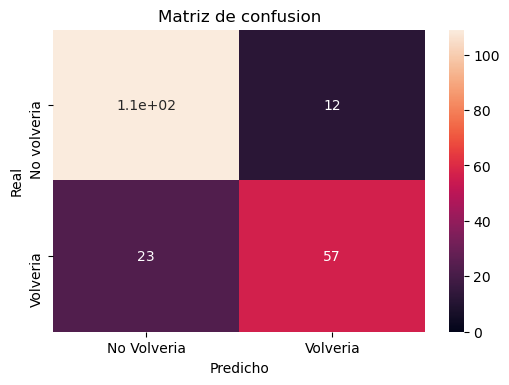

In [15]:
mostrarMatrizDeConfusion(y_pred,y_test)

Se observa que la matriz de confusión del árbol de decisión sin normalizar encontrado es muy buena. Un alto accuracy se puede ver claramente pues los valores de la diagonal invertida son significativamente menores que los de la diagonal principal.

De los 57 + 12 que el árbol predice que volverán, 57 efectivamente lo haría lo que indica un buen precision (83%)

El recall es un tanto mas bajo pues de los 23 + 57 que volverían, el árbol clasifica a 57 como personas que volverían, es decir detecta un poco mas de 2/3 de las personas que volverían (71%)

### Graficamos la curva ROC

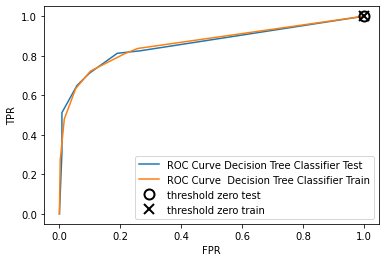

In [16]:
mostrarROCCurve(arbol_clasificador, "Decision Tree Classifier",X_test, X_train, y_test, y_train)

Podemos ver que las curvas ROC de train y test están casi superpuestas indicando que no hay mucha diferencia entre la clasificacón sobre test y sobre train. Esto es bueno porque indica que el modelo encontrado no overfittea, probablemente debido a que la profundidad del árbol es de 3.

In [17]:
mostrarAUCScore(arbol_clasificador, "Decision Tree Classifier", X_test, y_test)

AUC para Decision Tree Classifier: 0.860


Es un AUC score muy bueno, sobre todo considerando que el clasificador de árbol de decisión es uno de los mas simples. Además considerando que la profundidad del árbol es de 3, el árbol es muy simple. 

### Expansión del Análisis: ¿Cuáles son los features mas relevantes para decidir si alguien volvería o no a ver la película?

Como se mencionó anteriormente, una de las ventajas del árbol de decisión es su fácil interpretabilidad. Al observar el árbol podremos darnos una idea de cuáles son los features que mejor separan a las clases y que permiten una buena clasificación. Esto se debe a que para agregar un feature a los nodos del árbol este debe ser aquel que maximice la ganancia de información o la pureza de Gini.

In [18]:
arbol_clasificador = DecisionTreeClassifier(criterion= 'gini', max_depth= 3)

In [19]:
arbol_clasificador.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3)

In [20]:
dot_data = tree.export_graphviz(arbol_clasificador, class_names=["No Volveria", "Volveria"], feature_names=nombre_de_los_features) 
graph = graphviz.Source(dot_data, format='png')
graph.render("Arbol de decision")

'Arbol de decision.png'

<img src="Arbol de decision.png">

Como esperabamos, y en concordancia con el análisis realizado en la primera parte del trabajo, se puede observar que el feature mas relevante es el **género**, pues ocupa el nodo raíz del árbol. Podemos ver claramente que es un feature muy bueno pues produce una división entre clases muy buena:

* De las 58 + 154 mujeres encuestadas, 154 volverían
* De los 315 + 73 hombres encuestados, 315 no volverían
    
Lo cuál claramente indica que las mujeres tienden a volver y los hombres no.

Además inicialmente podemos ver que de 600 personas encuestadas, 373 no volverían y 227 sí lo harían, lo cual indica que existe un leve desbalance entre las clases.

Además, podemos ver, tal como habíamos visto que la **edad** es influyente a la hora decidir volver a ver la película en el caso de los hombres, (habíamos analizado que las mujeres tendían a volver independientemente de su edad en el análisis exploratorio). Esto se puede ver en el árbol porque el subárbol izquierdo (el correspondiente a los hombres) tiene en cuenta la edad para realizar predicciones, mientras que el subárbol derecho (el que corresponde a las mujeres) no.

Se ve también que el árbol predice que los hombres jóvenes volverían más que los mayores.

En el caso de las mujeres, el segundo feature que se toma en cuenta es el del tipo de sala. 

El árbol, considera que si una mujer fue a una **sala 4d** entonces esta no volvería y que si no fue a sala 4d entonces volvería. Si bien esta pregunta es buena para definir que una mujer volvería, pues de las 6 + 109 que no fueron a sala 4d, 109 volverían, no es tan buena para definir cuáles mujeres no volverían, pues de las 52 + 45 que fueron a sala 4d, casi la mitad, 52, no volverían. La impureza de gini es contrastante en este caso: 0.099 en el primer caso y 0.497 en el segundo.

## Análisis con la expansión del dataset

Buscamos ahora mejorar la performance del modelo de árbol de decisión hallado añadiendo features mediante un preprocesado de expansión

In [21]:
X_expandido = expansionDelDataset(X)

columnas_codificables_extra = ['pago_categorizado','edades_estratificadas','categoria_invitados']
columnas_numericas_extra = ['2_clusters','4_clusters','10_clusters','cantidad_total_invitados','total_pagado']

nombre_de_los_features_expandidos, X_arbol_expandido  = conversionAVariablesNumericas(X_expandido,columnas_codificables_extra,columnas_numericas_extra)
X_expandido_train, X_expandido_test, y_expandido_train, y_expandido_test = train_test_split(X_arbol_expandido, y, test_size=0.25, random_state=0)

#### Árbol con datos de entrenamiento expandidos sin normalizar

In [22]:
arbol_clasificador_expandido = DecisionTreeClassifier()
arbol_clasificador_expandido = GridSearchCV(arbol_clasificador_expandido, {'criterion':('gini', 'entropy'), 'max_depth':[1,2,3,4,5,6,7,8,9,10]}, n_jobs = -1)
arbol_clasificador_expandido.fit(X_expandido_train, y_expandido_train)
y_pred_expandido = arbol_clasificador_expandido.predict(X_expandido_test)

In [23]:
print(classification_report(y_pred_expandido, y_test, target_names=["Volveria", "No Voleria"]))

              precision    recall  f1-score   support

    Volveria       0.91      0.85      0.88       129
  No Voleria       0.76      0.85      0.80        72

    accuracy                           0.85       201
   macro avg       0.84      0.85      0.84       201
weighted avg       0.86      0.85      0.85       201



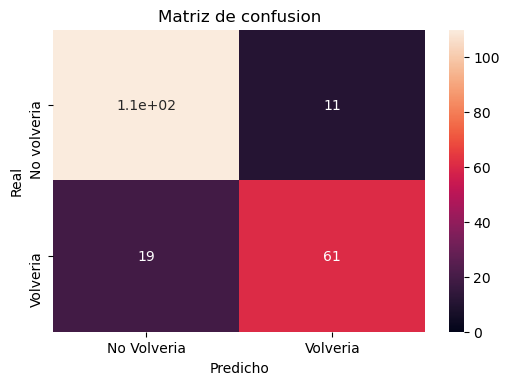

In [24]:
mostrarMatrizDeConfusion(y_pred_expandido,y_test)

In [25]:
mostrarAUCScore(arbol_clasificador_expandido, "Decision Tree Classifier", X_expandido_test, y_expandido_test)

AUC para Decision Tree Classifier: 0.876


Podemos ver que todas las métricas de este árbol mejoraron. Por lo que este es el mejor árbol que encontramos y es el que utilizaremos para realizar las predicciones de holdout.

## Predicciones sobre el nuevo archivo

Obtenemos y preparamos el nuevo archivo realizando el mismo preprocesamiento realizado en la sección anterior.

In [26]:
holdout = obtenerHoldout()
holdout = prepararSetDeHoldout(holdout)

nombres_de_las_variables, holdout_arbol = conversionAVariablesNumericas(holdout)

holdout_expandido = expansionDelDataset(holdout)
nombre_de_los_features_expandidos, holdout_arbol_expandido  = conversionAVariablesNumericas(holdout_expandido,columnas_codificables_extra,columnas_numericas_extra)

predicciones_holdout = arbol_clasificador_expandido.predict(holdout_arbol_expandido)
escribirPrediccionesAArchivo(predicciones_holdout,"Arbol de Decision")